<a href="https://colab.research.google.com/github/pj747/PRML/blob/master/cs6910_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dense, Flatten, Dropout, AveragePooling2D, BatchNormalization
from keras.layers.experimental.preprocessing import CenterCrop, Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
import cv2
import os
classList = ["Amphibia", "Animalia", "Arachnida", "Aves", "Fungi", "Insecta", "Mammalia", "Mollusca", "Plantae", "Reptilia"]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp /content/drive/MyDrive/CS6910/nature_12K.zip nature_12k.zip
!unzip nature_12k.zip

Streaming output truncated to the last 5000 lines.
  inflating: inaturalist_12K/train/Arachnida/1ac25349af662e85f577a31f64beca41.jpg  
  inflating: inaturalist_12K/train/Arachnida/117ef7f1812725f359500448a258e713.jpg  
  inflating: inaturalist_12K/train/Arachnida/6409254954c3b46d88d64f0bf4c632fa.jpg  
  inflating: inaturalist_12K/train/Arachnida/aaed865750bd52944658a7dd23366948.jpg  
  inflating: inaturalist_12K/train/Arachnida/460cc09ef510d400a4d47a836ddd45e6.jpg  
  inflating: inaturalist_12K/train/Arachnida/55c48c3afef0b745e53951284cdb2db4.jpg  
  inflating: inaturalist_12K/train/Arachnida/bff3daa961ee96a37ebe12dc0bcce504.jpg  
  inflating: inaturalist_12K/train/Arachnida/9082d4f2107bccf1f14d71c8944be607.jpg  
  inflating: inaturalist_12K/train/Arachnida/93d0130423d42f7c6228150eb95a2a93.jpg  
  inflating: inaturalist_12K/train/Arachnida/051aba6d7bc324bad76bd438ed3cc276.jpg  
  inflating: inaturalist_12K/train/Arachnida/67595af09c015c7753d5d4935677590f.jpg  
  inflating: inaturalist_

In [30]:
#RUN ONLY FOR WANDB

!pip install wandb
import wandb
from wandb.keras import WandbCallback
# !wandb login
# Uncomment
#RUN ONLY FOR WANDB

     |████████████████████████████████| 2.1MB 5.7MB/s 
     |████████████████████████████████| 102kB 7.9MB/s 
     |████████████████████████████████| 163kB 18.4MB/s 
     |████████████████████████████████| 133kB 20.6MB/s 
     |████████████████████████████████| 71kB 5.8MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=2b871b9ede58bcf610bc2a2b37b9764cff21dd55fc27c5b3a65da918a0fae04c
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=a785ba9e027546b443635984c7fa8fc2e8ad8bb28e477bd982b7c77c40a9a9fe
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


In [5]:
def createModel(layers, config):
  model = Sequential()
  dropout = config.dropout
  input_shape = (300,300,3)
  numFilters = layers[0][0]
  stride = layers[0][1]
  shape = layers[0][2]
  activation = layers[0][3]
  model.add(Conv2D(numFilters, shape, strides=stride, input_shape=input_shape))
  if config.batchNormalisation == "Yes":
      model.add(BatchNormalization())
  model.add(Activation(activation))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  if config.CNNdropout == "Yes":
      model.add(Dropout(config.dropout))
  for layer in layers[1::]:
    numFilters = layer[0]
    stride = layer[1]
    shape = layer[2]
    activation = layer[3]
    model.add(Conv2D(numFilters, shape, strides=stride))
    if config.batchNormalisation == "Yes":
      model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if config.CNNdropout == "Yes":
      model.add(Dropout(config.dropout))
  model.add(Flatten())
  model.add(Dropout(dropout))
  model.add(Dense(config.dense, activation='relu'))
  model.add(Dense(10, activation='softmax'))

  return model

def generateLayers(numFilters, stride, filterSize, organisation):
  layers = [[numFilters, stride, (filterSize,filterSize) ,'relu']]
  for i in range(4):
    if 4 <= numFilters * organisation and numFilters * organisation <= 256:
      numFilters = numFilters * organisation  
    layers.append([numFilters, stride, (filterSize,filterSize) ,'relu'])
  print(layers)
  return layers

In [6]:
def dataGenerator(augmentation):
  if (augmentation == "Yes"):
    generator = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            validation_split=0.1,
            fill_mode='nearest')
  else:
    generator = ImageDataGenerator(rescale=1./255, validation_split=0.1)
    
  trainDataGen = generator.flow_from_directory(
      '/content/inaturalist_12K/train',
      target_size=(300,300),
      batch_size = 64,
      class_mode = 'categorical',
      seed=123,
      subset="training",
  )
  valDataGen = generator.flow_from_directory(
      '/content/inaturalist_12K/train',
      target_size=(300,300),
      batch_size = 64,
      class_mode = 'categorical',
      seed=123,
      subset="validation",
  )
  return trainDataGen, valDataGen

In [7]:
"""
Config object is a dictionary, example given as below:
config={
        "numFilters" : 64,
        "stride" : 1,
        "filterSize" : 3,
        "dense" : 128,
        "filterOrganisation" : 1,
        "dataAugmentation" : 'No',
        'dropout' : 0.1,
        'CNNdropout' : "Yes",
        "batchNormalisation" : "Yes",
        "epochs" : 15
    }
"""
def createAndTrain(config, asDict=True, WandB=False):
  if asDict:
    from types import SimpleNamespace
    config = SimpleNamespace(
        numFilters = config["numFilters"],
        filterSize = config["filterSize"],
        dense = config["dense"],
        filterOrganisation = config["filterOrganisation"],
        dropout=config["dropout"],
        CNNdropout=config["CNNdropout"],
        batchNormalisation=config["batchNormalisation"],
        epochs=config["epochs"],
        stride=config["stride"],
        dataAugmentation=config["dataAugmentation"]
    )
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    print(
        '\n\nThis error most likely means that this notebook is not '
        'configured to use a GPU.  Change this in Notebook Settings via the '
        'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
    raise SystemError('GPU device not found')

  with tf.device('/device:GPU:0'):
    numFilters = config.numFilters
    size = config.filterSize
    stride = config.stride
    org = config.filterOrganisation

    layers = generateLayers(numFilters,stride,size,org)
    model = createModel(layers, config)

    optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=[keras.metrics.CategoricalAccuracy()])
    model.summary()
    trainDataGen, valDataGen = dataGenerator(config.dataAugmentation)
    if WandB:
      callbacks = [WandbCallback()]
    else:
      callbacks = []
    model.fit(x=trainDataGen, validation_data=valDataGen, epochs=config.epochs, callbacks=callbacks)
    #model.save('/content/drive/MyDrive/CS6910/Assignment_2_Models/' + str(run.id))
    #Uncomment to save trained model at a location in your drive folder
    #DO NOT UNCOMMENT FOR SWEEP

In [8]:
def wandbManual(config):
  run = wandb.init(project='cs6910-assignment2', entity='pj747', config=config)
  config = run.config
  createAndTrain(config, asDict=False, WandB=True)
  wandb.finish()

def wandbSweep():
  run = wandb.init()
  config = run.config
  createAndTrain(config, asDict=False, WandB=True)

Run the subsequent cell to train a model lovally. Use above two functions to run a single wandb instance, or a sweep.

In [36]:
createAndTrain(config={
        "numFilters" : 64,
        "stride" : 1,
        "filterSize" : 3,
        "dense" : 128,
        "filterOrganisation" : 2,
        "dataAugmentation" : 'No',
        'dropout' : 0.1,
        'CNNdropout' : "Yes",
        "batchNormalisation" : "Yes",
        "epochs" : 15
    })

wandb: Currently logged in as: pj747 (use `wandb login --relogin` to force relogin)


[[64, 1, (3, 3), 'relu'], [64, 1, (3, 3), 'relu'], [64, 1, (3, 3), 'relu'], [64, 1, (3, 3), 'relu'], [64, 1, (3, 3), 'relu']]
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 298, 298, 64)      1792      
_________________________________________________________________
batch_normalization_15 (Batc (None, 298, 298, 64)      256       
_________________________________________________________________
activation_15 (Activation)   (None, 298, 298, 64)      0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 149, 149, 64)      0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 147, 147, 64)      36928

KeyboardInterrupt: ignored

In [37]:
wandb.agent('yexstje9', project='cs6910-assignment2' ,function=wandbSweep)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6veazryb with config:
wandb: 	CNNdropout: No
wandb: 	batchNormalisation: Yes
wandb: 	dataAugmentation: Yes
wandb: 	dense: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	filterOrganisation: 0.5
wandb: 	filterSize: 3
wandb: 	numFilters: 64
wandb: 	stride: 1


[[64, 1, (3, 3), 'relu'], [32.0, 1, (3, 3), 'relu'], [16.0, 1, (3, 3), 'relu'], [8.0, 1, (3, 3), 'relu'], [4.0, 1, (3, 3), 'relu']]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 298, 298, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 298, 298, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 147, 147, 32)      1

wandb: Ctrl + C detected. Stopping sweep.


In [13]:
def evaluationDataGenerator(dataAugmentation):
  if (dataAugmentation == "Yes"):
    generator = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')
  else:
    generator = ImageDataGenerator(rescale=1./255)

  trainDataGen = generator.flow_from_directory(
      '/content/inaturalist_12K/train',
      target_size=(300,300),
      batch_size = 64,
      class_mode = 'categorical',
      seed=123
  )
  
  return trainDataGen

def finalTest():
  #final function to save model with configuration obtained by sweeps
  #by training against full data
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    print(
        '\n\nThis error most likely means that this notebook is not '
        'configured to use a GPU.  Change this in Notebook Settings via the '
        'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
    raise SystemError('GPU device not found')

  with tf.device('/device:GPU:0'):
    run = wandb.init(project='cs6910-assignment2', entity='pj747', config={
        "numFilters" : 64,
        "stride" : 1,
        "filterSize" : 3,
        "dense" : 128,
        "filterOrganisation" : 1,
        "dataAugmentation" : 'No',
        'dropout' : 0.1,
        'CNNdropout' : "Yes",
        "batchNormalisation" : "Yes",
        "epochs" : 15
    })

    config = run.config
    numFilters = config.numFilters
    size = config.filterSize
    stride = config.stride
    org = config.filterOrganisation
    layers = generateLayers(numFilters,stride,size,org)
    
    model = createModel(layers, config)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[keras.metrics.CategoricalAccuracy()])
    model.summary()
    trainDataGen = evaluationDataGenerator(config.dataAugmentation)
    checkpoint_filepath = '/content/checkpoint/' + str(run.id)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='categorical_accuracy',
      mode='max',
      save_best_only=False)
    model.fit(x=trainDataGen, epochs=config.epochs, callbacks=[WandbCallback(), model_checkpoint_callback])
    model.save('/content/drive/MyDrive/CS6910/Assignment_2_Models/' + str(run.id))
    testGenerator = ImageDataGenerator(rescale=1./255)
    testDataGen = testGenerator.flow_from_directory(
        '/content/inaturalist_12K/val',
        target_size=(300,300),
        batch_size = 64,
        class_mode = 'categorical',
        seed=123
    )
    results = model.evaluate(x=testDataGen)
    wandb.log({"test_categorical_accuracy":results[1], "test_loss":results[0]})
    wandb.finish()
    return model
    

In [5]:
#model = finalTest()
#UNCOMMENT IF YOU WANT TO TEST THIS MODEL
#TAKES AROUND 30 MINUTES
#Otherwise, you can load the model by copying this folder to your drive.
model = keras.models.load_model('/content/drive/MyDrive/CS6910/Assignment_2_Models/uc8jxcio')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 298, 298, 64)      1792      
_________________________________________________________________
batch_normalization_5 (Batch (None, 298, 298, 64)      256       
_________________________________________________________________
activation_5 (Activation)    (None, 298, 298, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 149, 149, 64)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 147, 147, 64)      36928     
_________________________________________________________________
batch_normalization_6 (Batch (None, 147, 147, 64)     

This cell generates the 64 images representing the first convolutional layer as feature maps for a representative image of a bird.

Model: "model_348"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5_input (InputLayer)  [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 298, 298, 64)      1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________
(1, 300, 300, 3)


wandb: Currently logged in as: pj747 (use `wandb login --relogin` to force relogin)


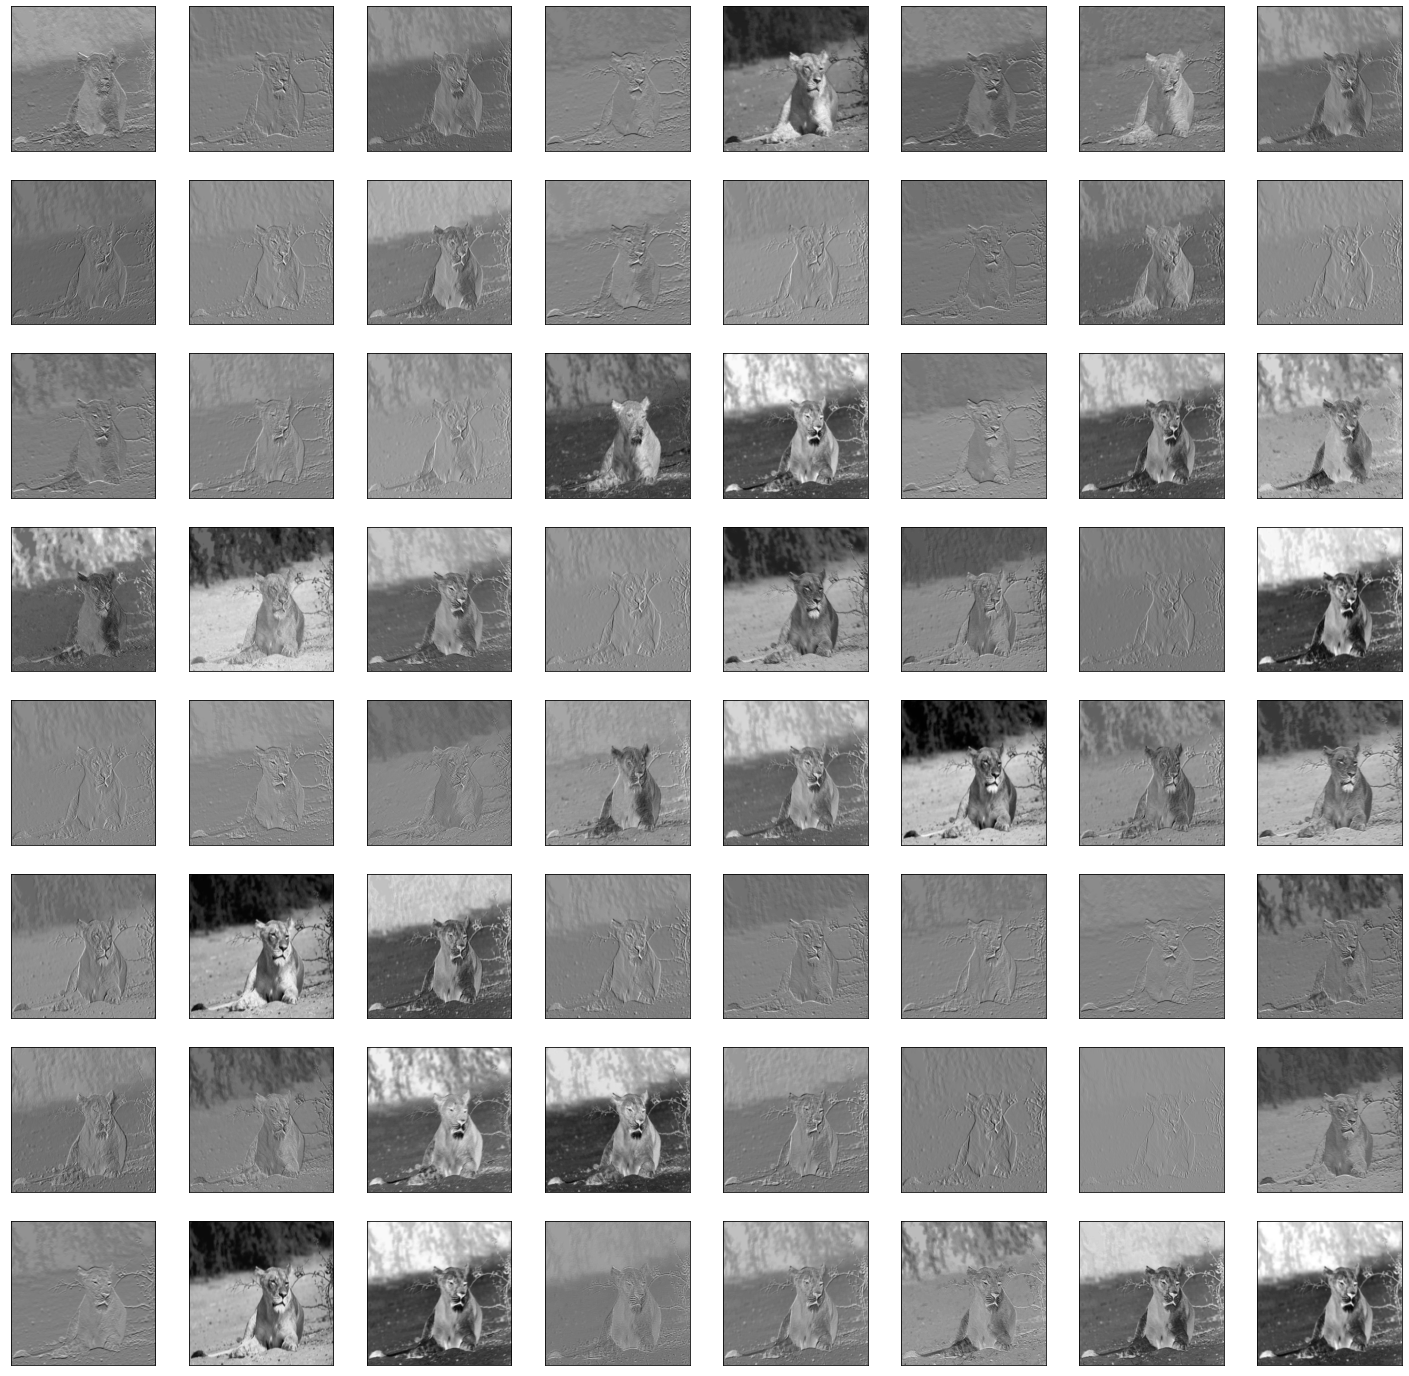

In [39]:
# model.summary()
newModel = keras.models.Model(inputs=model.inputs[0], outputs=model.layers[0].output)
newModel.summary()



img = load_img('/content/inaturalist_12K/train/Mammalia/1a907e37059f0811cc2b18170998cc57.jpg', target_size=(300,300))


img = img_to_array(img)
img = np.expand_dims(img, axis=0)

img /=255
print(img.shape)
feature_maps = newModel.predict(img)
square = 8
ix = 1
# plt.imshow(img)
plt.figure(figsize=(25,25))
for _ in range(square):
  for _ in range(square):
    ax = plt.subplot(square, square, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
    ix += 1


wandb.init(project='cs6910-assignment2', entity='pj747', config={}, name="DATARUN")
wandb.log({"Filters":plt})
wandb.finish()

plt.show()

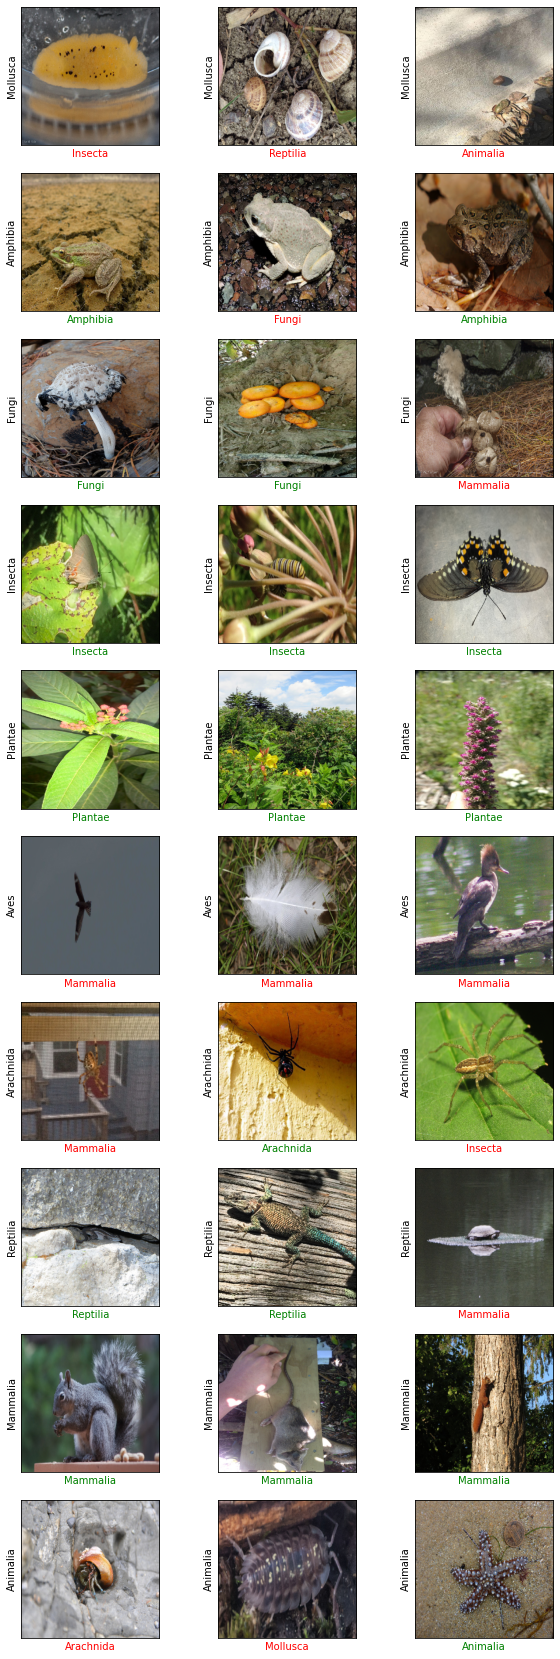

In [51]:

img_folder = '/content/inaturalist_12K/train'
plt.figure(figsize=(10,30))
count = 0
for dir1 in os.listdir(img_folder):
      if not os.path.isdir(os.path.join(img_folder, dir1)):
          continue
      fileCount=1
      for file in os.listdir(os.path.join(img_folder, dir1)):
        if (fileCount) <= 3:
          image_path= os.path.join(img_folder, dir1,  file)
          img = load_img(image_path, target_size=(300,300))
          img = img_to_array(img)
          toPlot =img/255
          input = np.expand_dims(toPlot, axis=0)
          predictions = model.predict(input)
          index = np.argmax(predictions[0])
          output = classList[index]
          ax = plt.subplot(10, 3, count+1)
          ax.set_xticks([])
          ax.set_yticks([])
          if output == dir1:
            ax.xaxis.label.set_color('green')
          else:
            ax.xaxis.label.set_color('red')
          ax.set_xlabel(output)
          ax.set_ylabel(dir1)
          plt.imshow(toPlot)
          count += 1
          fileCount+=1
        else:
          break

# wandb.init(project='cs6910-assignment2', entity='pj747', config={}, name="DATARUN")
# wandb.log({"Grid":plt})
# wandb.finish()

# Guided Backpropagation
The following cells use tensorflow API of gradient tape to calculate gradient to do backpropagation by overloading relu's gradient. Code is inspired by https://colab.research.google.com/drive/17tAC7xx2IJxjK700bdaLatTVeDA02GJn?usp=sharing a publicly available demo. 

In [14]:
@tf.custom_gradient
def guidedRelu(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad

[[ 4394  7701  6088  6143  9242 11890  6344  7372   988  5047]]


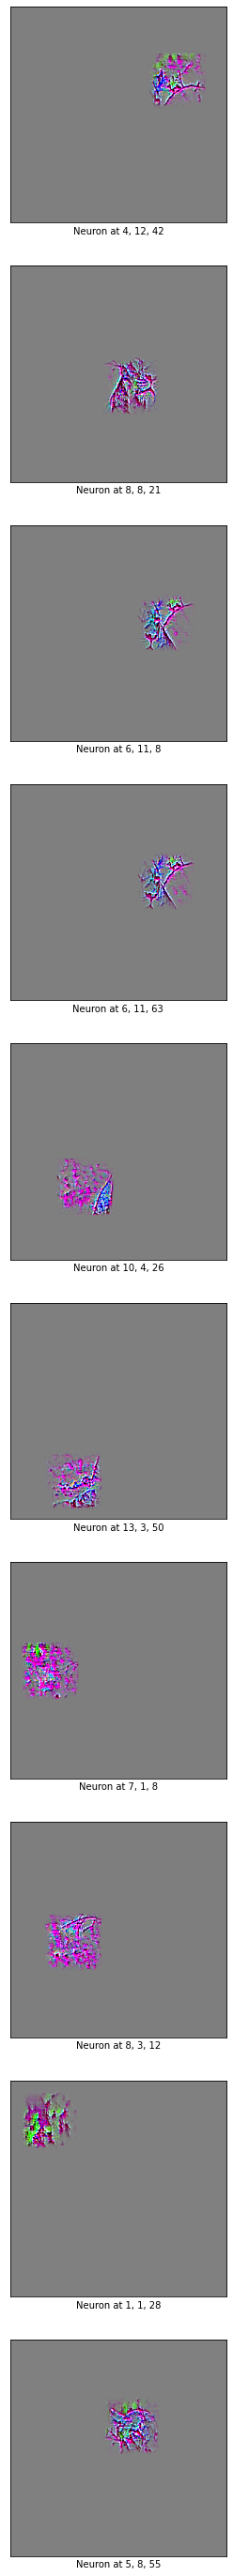

In [34]:
def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + keras.backend.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if keras.backend.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

image_path = '/content/inaturalist_12K/train/Mammalia/1a907e37059f0811cc2b18170998cc57.jpg'
img = load_img(image_path, target_size=(300,300))
img = img_to_array(img)
toPlot =img/255
input = np.expand_dims(toPlot, axis=0)
plt.figure(figsize=(5,50))
indices = np.random.randint(0, 14*14*64-1,(1,10))
print(indices)
count = 0
for index in indices[0]:
    count +=1
    k = index % 64
    j = (index // 64) % 14
    i = (index // (64 * 14) % 14)
    gb_model = keras.models.Model(
        inputs = [model.inputs],
        outputs = [model.get_layer("conv2d_9").output[0][i][j][k]]
    )
    layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]
    for layer in layer_dict:
      if layer.activation == tf.keras.activations.relu:
        layer.activation = guidedRelu

    with tf.GradientTape(persistent=True) as tape:
      inputs = tf.convert_to_tensor(input, dtype=tf.float32) 
      tape.watch(inputs)
      outputs = gb_model(inputs)

    grads = tape.gradient(outputs,inputs)[0]
    ax = plt.subplot(10,1,count)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("Neuron at " + str(i) +", "+ str(j)+", "+ str(k))
    plt.imshow(np.flip(deprocess_image(np.array(grads)),-1))
wandb.init(project='cs6910-assignment2', entity='pj747', config={}, name="DATARUN")
wandb.log({"Guided Backprop on Neurons": plt})

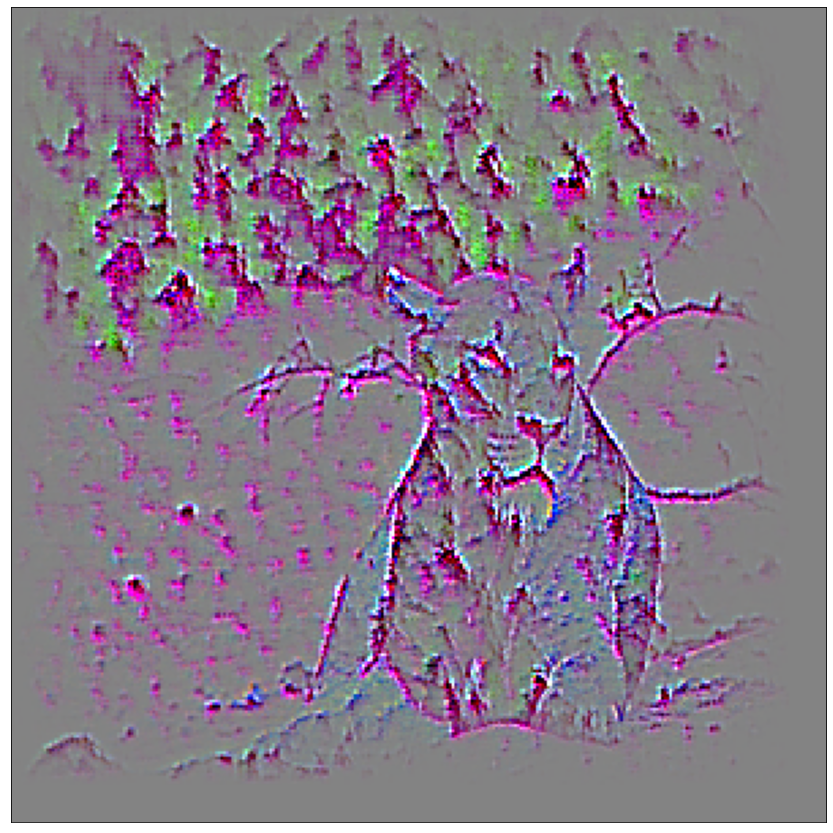

In [37]:
image_path = '/content/inaturalist_12K/train/Mammalia/1a907e37059f0811cc2b18170998cc57.jpg'
img = load_img(image_path, target_size=(300,300))
img = img_to_array(img)
toPlot =img/255
input = np.expand_dims(toPlot, axis=0)
gb_model = keras.models.Model(
          inputs = [model.inputs],
          outputs = [model.get_layer("conv2d_9").output[0]]
      )
layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]
for layer in layer_dict:
  if layer.activation == tf.keras.activations.relu:
    layer.activation = guidedRelu

with tf.GradientTape(persistent=True) as tape:
  inputs = tf.convert_to_tensor(input, dtype=tf.float32) 
  tape.watch(inputs)
  outputs = gb_model(inputs)
plt.figure(figsize=(15,15))
ax = plt.subplot(1,1,1)
ax.set_xticks([])
ax.set_yticks([])
grads = tape.gradient(outputs,inputs)[0]

plt.imshow(np.flip(deprocess_image(np.array(grads)),-1))
wandb.log({"Guided Backprop Complete": plt})
wandb.finish()

In [12]:
print(grads.shape)
classList = ["Amphibia", "Animalia", "Arachnida", "Aves", "Fungi", "Insecta", "Mammalia", "Mollusca", "Plantae", "Reptilia"]
input = np.expand_dims(toPlot, axis=0)
predictions = model.predict(input)
index = np.argmax(predictions[0])
print(classList[index])


(300, 300, 3)
Mammalia


In [ ]:

IMG_HEIGHT = 300
IMG_WIDTH = 300
def create_dataset(img_folder):
   
    train_data_array=[]
    train_label_array=[]
    val_data_array = []
    val_label_array = []
    for dir1 in os.listdir(img_folder):
        count = 0
        if not os.path.isdir(os.path.join(img_folder, dir1)):
            continue
        print(dir1)
        for file in os.listdir(os.path.join(img_folder, dir1)):
            
            image_path= os.path.join(img_folder, dir1,  file)
            
            image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
            if image is None:
              continue
            cr_image = cv2.resize(image, (300,300))
            if (cr_image.shape!=(IMG_WIDTH,IMG_HEIGHT,3)):
              continue
            image=np.array(cr_image)
            image = image.astype('float32')
            image /= 255 
            if count>=900:
              val_data_array.append(image)
              val_label_array.append(dir1)
            else:
              train_data_array.append(image)
              train_label_array.append(dir1)
            count+=1
    return np.array(train_data_array), np.array(oneHotfromClass(train_label_array)), np.array(val_data_array), np.array(oneHotfromClass(val_label_array))
    
def oneHotfromClass(y):
    target_dict={"Amphibia":0, "Mammalia":1, "Insecta":2, "Plantae":3, "Aves":4, "Mollusca":5, "Reptilia":6, "Fungi":7, "Arachnida":8, "Animalia":9}
    target_val=  [target_dict[y[i]] for i in range(len(y))]
    return to_categorical(target_val)

def center_crop(img, dim):
	"""Returns center cropped image
	Args:
	img: image to be center cropped
	dim: dimensions (width, height) to be cropped
	"""
	width, height = img.shape[1], img.shape[0]

	# process crop width and height for max available dimension
	crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
	crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0] 
	mid_x, mid_y = int(width/2), int(height/2)
	cw2, ch2 = int(crop_width/2), int(crop_height/2) 
	crop_img = img[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
	return crop_img

X_train, Y_train, X_val, Y_val = create_dataset('/content/inaturalist_12K/train')

Fungi
Mammalia
Aves
Mollusca
Animalia
Reptilia
Arachnida
Insecta
Amphibia
Plantae
